# Tutorial: Deep Learning for PDEs - Comparing FEM, PINN, and GNN

Welcome to this introductory tutorial on solving Partial Differential Equations (PDEs) using neural networks. This notebook is designed to guide you through the transition from traditional numerical methods (FEM) to modern deep learning approaches (PINNs and GNNs).

## 1. Introduction: The Poisson Equation

The **Poisson equation** is a fundamental elliptic PDE used in physics and engineering to describe electrostatics, steady-state heat conduction, and fluid flow.

### Mathematical Formulation
We seek to find a scalar function $u(x, y)$ that satisfies:

$$-\Delta u(x, y) = f(x, y) \quad \forall (x, y) \in \Omega$$
$$u(x, y) = 0 \quad \forall (x, y) \in \partial\Omega$$

Where:
- $\Omega$: The **spatial domain**, defined here as a unit square $[0, 1] \times [0, 1]$.
- **Time Domain**: Since this is a steady-state problem, the **simulation time** is $t=0$. The solution represents a static equilibrium. However, the models are built to anticipate future time-dependent variables $u(x, t)$.
- $\Delta$: The Laplace operator $\nabla \cdot \nabla$, representing diffusion or curvature.
- $f(x, y)$: The **source term**, which "drives" the solution (e.g., heat generation or charge density).

### Modeling Approaches
1. **Finite Element Method (FEM)**: A classical mesh-based technique that discretizes the space into simple elements (triangles).
2. **Physics-Informed Neural Networks (PINN)**: A continuous, mesh-free approach that solves the PDE by minimizing residuals using Autograd.
3. **Graph Neural Networks (GNN)**: A physics-aware modern approach that operates on the mesh graph, learning to map topology to solutions.


In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
import pytorch_lightning as pl

# Local modules
# Add the project root to path so we can import our modules
sys.path.append(os.path.abspath(os.path.join('..')))
from FEM.fem_solver import get_problem
from config.physics import *
from utils.plotting import *
from utils.metrics import *
from utils.train_utils import * 
from utils.reporting import *

pl.seed_everything(42)

Seed set to 42


42

## 2. The Numerical Baseline: Finite Element Method (FEM)

Before training neural networks, we need a **Ground Truth**. FEM discretizes the domain into a mesh of triangles and solves the equation by converting it into a linear system $Ku = F$.

FEM approximates $u$ by combining "hat" functions defined on a mesh. 


In [2]:
# ==========================================
# STEP 1: DEFINE PHYSICS & MESH PARAMETERS
# ==========================================
# You can change 'sine' to 'const' to see how the solution changes

nelem = 2               # Mesh resolution (nelem x nelem)
porder = 2              # Polynomial order (Lin or cuad elements)
mesh_type = 'quad'       # Mesh type: 'tri' or 'quad'
source_type = 'sine'    # Source term type: 'constant' or 'sine'

prob = get_problem(nx=nelem, ny=nelem, porder=porder, source_type=source_type, mesh_type=mesh_type)
u_exact = prob['u_exact']
doflocs = prob['basis'].doflocs.T

print(f"Configuring FEM for {source_type} source term...")
phys = PoissonPhysics(source_type=source_type)
print(f"FEM Solution ready with {len(doflocs)} Degree of Freedom (DOF).")

Configuring FEM for sine source term...
FEM Solution ready with 25 Degree of Freedom (DOF).


### Mesh Configuration
We use a structured triangular mesh with the following parameters (aligned with the `CircleDeterministic.py` reference):

| Parameter | Description | Default Value |
| :--- | :--- | :--- |
| `nelem` | Number of subdivisions along one side | 2 |
| `porder` | Polynomial order of the basis functions | 2 (Quadratic) |
| `source` | Source term type $f(x, y)$ | 'sine' |
| `domain` | Spatial extent | $[0, 1]^2$ |
| `t_sim`  | Simulation Time | Static ($t=0$) |

In [3]:
# Create a dictionary from your notebook variables for the report
FEM_CONFIG = {
    'nelem': nelem,
    'porder': porder,
    'mesh_type': mesh_type,
    'source_type': source_type
}

# Display summary
print_config_summary(model=prob, config=FEM_CONFIG, model_type="FEM")


### FEM CONFIGURATION SUMMARY


,Hyperparameter,Description,Value
0,`nelem`,Mesh resolution (Elements per side),2
1,`porder`,"Polynomial order (1: Linear, 2: Quadratic)",2
2,`mesh_type`,Element geometry (tri/quad),quad
3,`source_type`,Physics source term function,sine


### FEM: mesh visualization

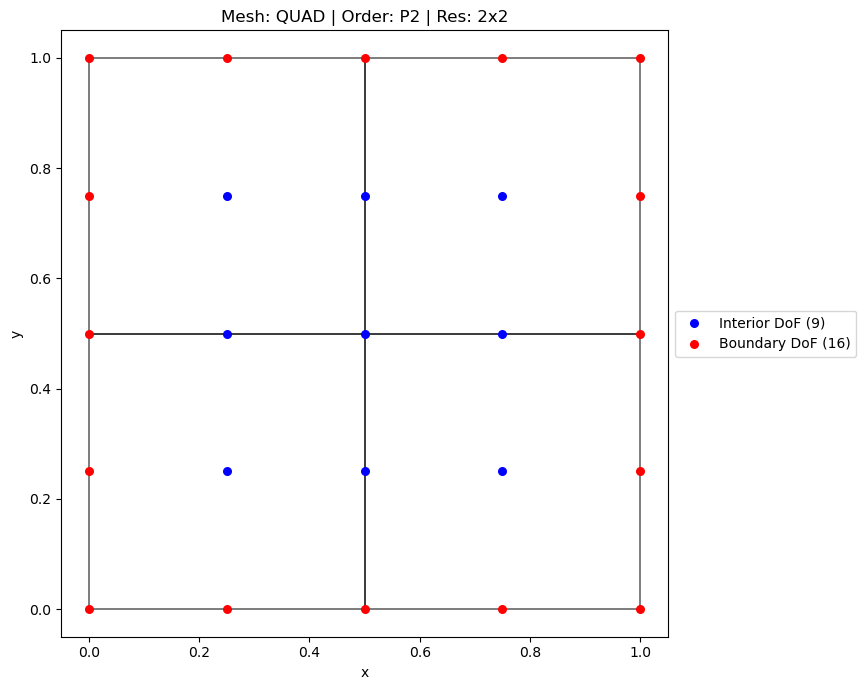

--- Ficha Técnica de la Malla ---
Estructura: QUAD | Orden: P2
Resolución: 2x2 elementos
Total DoFs (Nodos de cálculo): 25


In [4]:
# ==========================================
# STEP 2: AUTOMATIC MESH VISUALIZATION
# ==========================================
# 1. Mesh configuration based on user parameters
prob = get_problem(
    nx=nelem, 
    ny=nelem, 
    porder=porder, 
    mesh_type=mesh_type, 
    source_type=source_type
)

# 2. Automatic mesh plotting function tri/cuad
plot_fem_mesh(
    prob, 
    title=f"Mesh: {mesh_type.upper()} | Order: P{porder} | Res: {nelem}x{nelem}"
)

plt.show()

# =========================================
print(f"--- Ficha Técnica de la Malla ---")
print(f"Estructura: {mesh_type.upper()} | Orden: P{porder}")
print(f"Resolución: {nelem}x{nelem} elementos")
print(f"Total DoFs (Nodos de cálculo): {len(prob['doflocs'])}")

### FEM Results

The FEM solution serves as our reference for the neural network training.

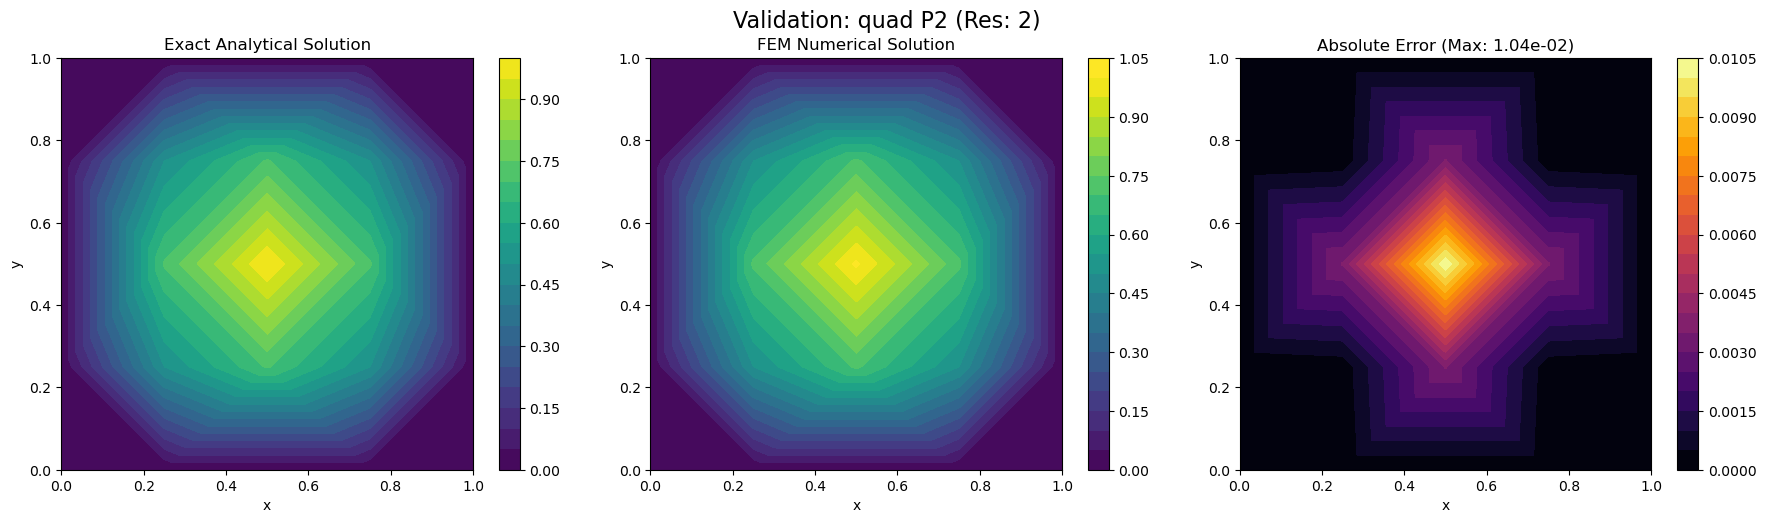

Mean Squared Error (Nodes): 0.002519
REPORT: quad P2


,Métrica,Valor
0,Error Absoluto Máximo (L_inf),1.041325e-02
1,Error Absoluto Promedio (MAE),1.007423e-03
2,MSE (Mean Squared Error),6.347099e-06
3,RRMSE (Relative RMSE),0.251934%


In [5]:
# ==========================================
# STEP 3: SOLVE FEM and VISUALIZE GROUND TRUTH
# ==========================================
# Validation plots
plot_fem_validation(prob, title=f"Validation: {mesh_type} P{porder} (Res: {nelem})")
plt.show()

# Error calculation
l2_error = np.sqrt(np.mean((prob['u'] - prob['u_exact'])**2))
print(f"Mean Squared Error (Nodes): {l2_error:.6f}")

df_metrics, raw_metrics = calculate_fem_metrics(prob['u'], prob['u_exact'])
print(f"REPORT: {mesh_type} P{porder}")
display(df_metrics)


## 3. PINN Resolution

**What does it do?** A PINN learns a continuous function $u_\theta(x, y)$ that minimizes the PDE residuals.
**Inputs:** Coordinates $(x, y)$.
**Output:** The scalar field $u$.
**Sampling strategy:** We sample **Collocation Points** inside the domain to enforce the physics. For this benchmark, we match the density of the FEM mesh.

In [6]:
# ============================================================
# STEP 5: INDEPENDENT DATA STRATEGY (TRAIN vs TEST)
# ============================================================
import torch
import numpy as np

from PINN.pinn_module import PINNSystem
from config.physics import PoissonPhysics

# --- Manual Control Dashboard ---
# Training Strategy (Physics enforcement)
use_fem_for_train = False   # True: Train on FEM nodes | False: Random sampling
use_fem_for_test  = False
n_train = 50    # Independent Physics points (Train)
n_test  = 50    # Independent Evaluation points (Test)
n_bc    = 50   # Boundary points
n_train_random    = n_train      # Only used if use_fem_for_train is False
n_test_random     = n_test      # Only used if use_fem_for_test is False
n_boundary        = n_bc      # Points for BCs

# Model Hyperparameters
hidden_dim       = 64
num_layers       = 4
lr               = 1e-3
epochs           = 5000
lambda_bc        = 100.0

# --- 1. Generate TRAIN Points (The "Physics" set) ---
if use_fem_for_train:
    # Inherit nodes from FEM mesh as training points
    train_pts = torch.tensor(prob['doflocs'], dtype=torch.float32).requires_grad_(True)
    train_label = f"FEM Nodes ({len(train_pts)})"
else:
    # Sample a specific number of random points in the domain
    train_pts = torch.rand(n_train_random, 2).requires_grad_(True)
    train_label = f"Random Train ({n_train_random})"

# --- 2. Generate TEST Points (The "Evaluation" set) ---
if use_fem_for_test:
    # Evaluate accuracy only on FEM nodes
    test_pts = torch.tensor(prob['doflocs'], dtype=torch.float32)
    test_label = f"FEM Nodes ({len(test_pts)})"
else:
    # Evaluate accuracy on a dense cloud of points (continuous evaluation)
    test_pts = torch.rand(n_test_random, 2)
    test_label = f"Random Test ({n_test_random})"

# 3. Creamos la instancia con la configuración que queramos
my_physics = PoissonPhysics(source_type='sine', scale=1.0)

# --- 4. Update Configuration and Initialize Model ---
PINN_CONFIG = {
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'lr': lr,
    'epochs': epochs,
    'lambda_bc': lambda_bc,
    'use_fem_for_train': use_fem_for_train,
    'use_fem_for_test': use_fem_for_test,
    'n_collocation': len(train_pts), # Directly from the points we just created
    'n_boundary': n_boundary
}

pinn = PINNSystem(**PINN_CONFIG, collocation_points=train_pts, physics=my_physics)

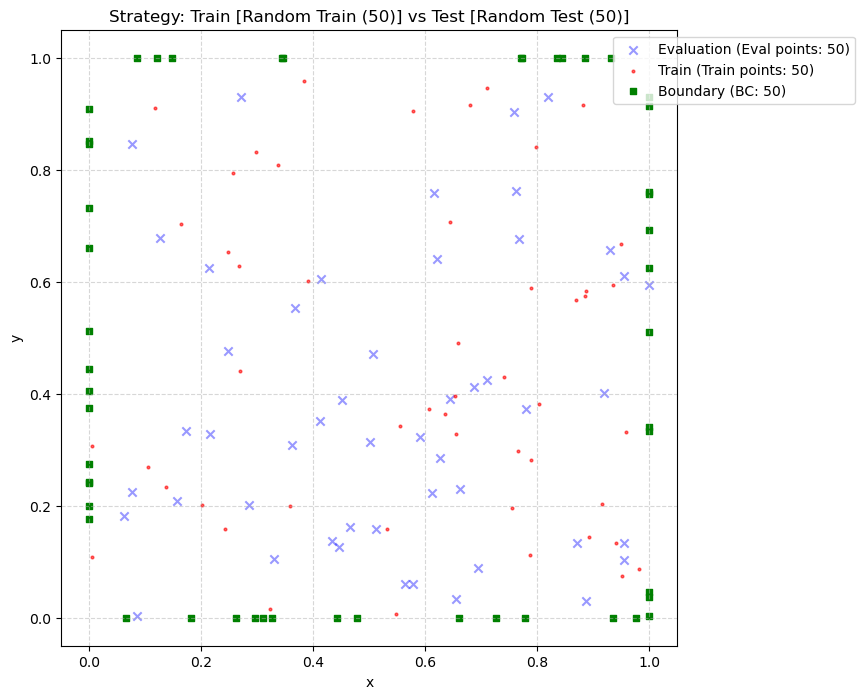

In [7]:
# --- 4. Data Split Visualization ---
# Green points (BC) generation for plot
bc_pts_plot = torch.rand(n_boundary, 2).numpy()
side_mask = torch.randint(0, 4, (n_boundary,))
bc_pts_plot[side_mask==0, 0] = 0.0; bc_pts_plot[side_mask==1, 0] = 1.0
bc_pts_plot[side_mask==2, 1] = 0.0; bc_pts_plot[side_mask==3, 1] = 1.0

plot_pinn_sampling(
    eval_points=test_pts.numpy(),            # BLUE: Evaluation/Test set
    train_points=train_pts.detach().numpy(),   # RED: Training/Physics set
    bc_points=bc_pts_plot,                   # GREEN: Boundary set
    title=f"Strategy: Train [{train_label}] vs Test [{test_label}]"
)
plt.show()

In [8]:
# --- 4. Configuration Report ---
from utils.reporting import print_config_summary

print_config_summary(pinn, PINN_CONFIG, model_type="PINN")


### PINN CONFIGURATION SUMMARY


,Hyperparameter,Description,Value
0,`hidden_dim`,Width of the MLP layers,64
1,`num_layers`,Number of hidden layers,4
2,`lr`,Learning rate (Adam),0.001
3,`epochs`,Maximum training iterations,5000
4,`lambda_bc`,Weight penalty for Boundary Conditions,100.0
5,`use_fem_for_train`,Use FEM mesh points for training,False
6,`use_fem_for_test`,Use FEM mesh points for testing,False
7,`n_collocation`,Train points (Interior PDE residual),50
8,`n_boundary`,Train points (Boundary conditions),50
9,`Actual Train Pts`,Final count of interior points used,50


In [9]:
# ============================================================
# STEP 2: TRAINER SETUP WITH GRADIENT MONITORING
# ============================================================
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from utils.train_utils import GradientMonitor # Import from your new file

# 1. Validation Data (FEM nodes)
x_val = torch.tensor(prob['doflocs'], dtype=torch.float32)
u_val = torch.tensor(prob['u'], dtype=torch.float32)
val_loader = [(x_val, u_val)]

# 2. Define Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=150, # Increased for PINNs as they can plateau
        mode='min', 
        verbose=True
    ),
    ModelCheckpoint(
        monitor='val_loss', 
        save_top_k=1, 
        mode='min',
        filename='best_pinn_{epoch}'
    ),
    GradientMonitor(verbose=True)
]

# 3. Initialize Trainer
trainer = pl.Trainer(
    max_epochs=PINN_CONFIG['epochs'],
    accelerator="auto",
    devices=1,
    callbacks=callbacks,
    track_grad_norm=2, # Lightning's built-in feature for deeper logging
    log_every_n_steps=10
)

# 4. Start Optimization
trainer.fit(pinn, train_dataloaders=None, val_dataloaders=val_loader)

TypeError: Trainer.__init__() got an unexpected keyword argument 'track_grad_norm'

## 4. Graph Neural Network (GNN) Resolution

**What does it do?** A GNN operates on the mesh nodes. It uses **Message Passing** to gather information from neighbors and refine its prediction.
**Approach:** In this step, the GNN is **Supervised**. It learns to map node coordinates to the FEM solution $U(x, t)$.
**Connectivity:** Defined by the FEM mesh edges (adjacent neighbors).

### GNN Configuration

| Hyperparameter | Description | Value |
| :--- | :--- | :--- |
| `hidden_dim` | Width of Graph layers | 32 |
| `num_layers` | Message passing steps | 3 |
| `lr` | Learning rate | 1e-3 |
| `epochs` | Training iterations | 500 |
| `supervised` | Training against FEM targets | Yes |
| `connectivity` | Graph edges type | Mesh-based |

In [ ]:
dataset = PINNGraphDataset(nelem=nelem, porder=porder)
system_gnn = GNNSystem(hidden_dim=32, num_layers=3, lr=1e-3, supervised=True)
trainer_gnn = pl.Trainer(max_epochs=500, accelerator='auto', enable_checkpointing=False, log_every_n_steps=1)
trainer_gnn.fit(system_gnn, DataLoader(dataset, batch_size=1))

u_gnn = system_gnn(dataset[0]['x'].to(system_gnn.device), dataset[0]['edge_index'].to(system_gnn.device)).detach().cpu().numpy().flatten()
plot_comparison_with_fem(u_exact, u_gnn, doflocs, None, "GNN")
plt.show()

plot_error_analysis(u_exact, u_gnn, None, "GNN")
plt.show()

## 5. PINN vs GNN: Comparative Analysis

### Recap
- **PINN** learned the physics by looking at the interior PDE residuals. It is mesh-free but requires careful sampling.
- **GNN** learned the behavior of the solution by observing the FEM ground truth. It is extremely fast at inference and understands the domain topology.

| Feature | PINN | GNN (Supervised) |
| :--- | :--- | :--- |
| Need for Mesh | No | Yes |
| Learning Target | PDE Residual | FEM Data |
| Flexibility | High (any geometry) | Medium (restricted to graph) |
| Accuracy | Smooth/Global | Local/Topology-aware |

**Conclusion**: This tutorial demonstrates that both physics-informed and data-driven neural networks can approximate PDE solutions. In advanced cases, we combine these (PiGNN) to use the graph structure while enforcing physics residuals directly on the mesh nodes.